# Machine Learning Lab

This project aims at comparing the efficiency of Convolutional Neural Networks (CNN) with respect to Random Forest (RF) algorithms for the classification of data in the MNIST dataset. 

In [1]:
from cnn import CNN
from data_loader import DataLoader
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

## Convolutional Network

We shall compare different optimizers in order to improve performance when the neural network is tested against the RF approach. Here follow the candidates.

In [7]:
optimizers = ['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

The NN is configured as below.

In [8]:
config_dicts = [{
    'epochs': 5,
    'dropout': 0.2,
    'batch_size': 32,
    'optimizer': optimizer,
    'dataset': keras.datasets.fashion_mnist,
} for optimizer in optimizers]

neuralnets = [CNN(config_dict) for config_dict in config_dicts]

2022-10-03 10:25:36.679116: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-03 10:25:36.679313: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 10:25:36.680095: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
history = [neuralnet.fit() for neuralnet in neuralnets]

NameError: name 'history' is not defined

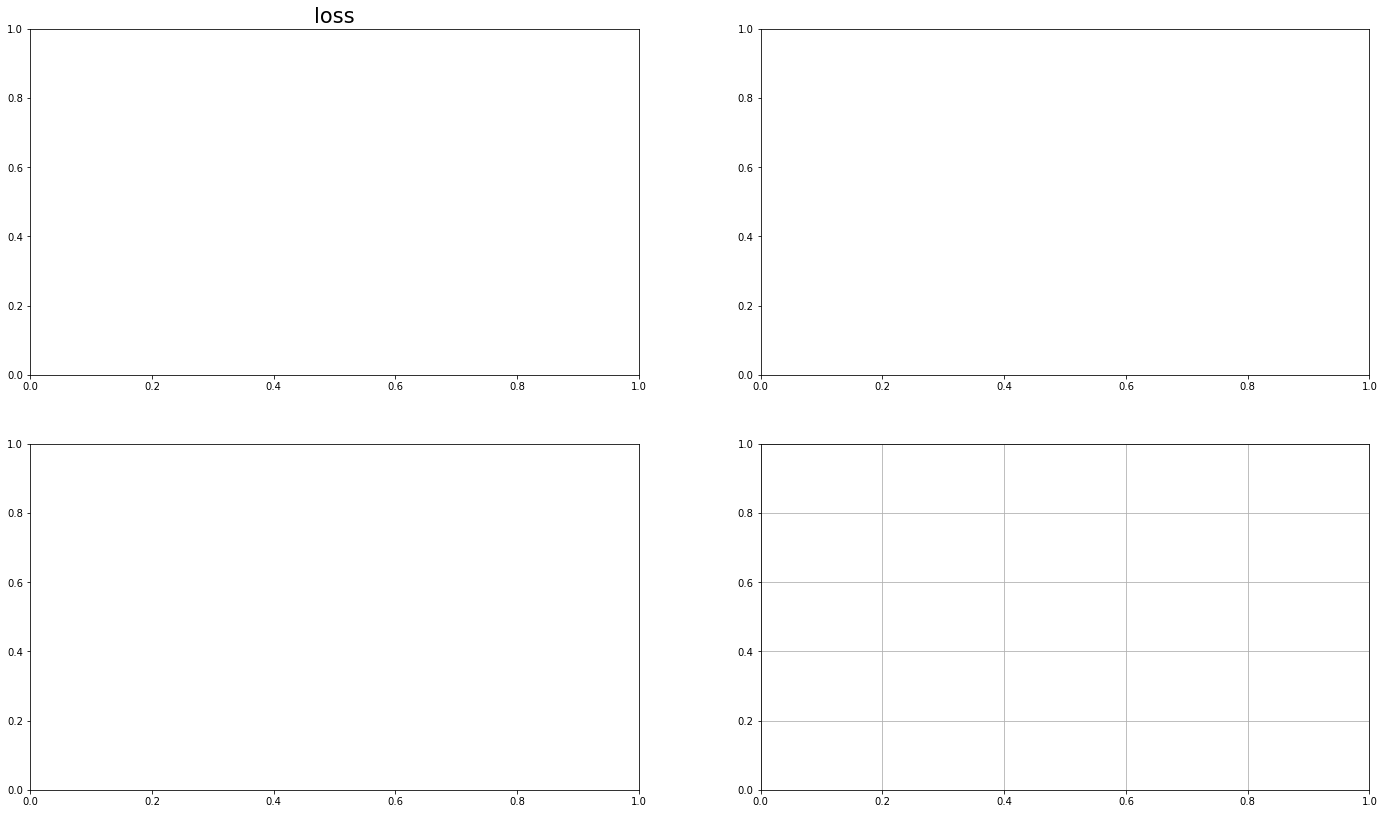

In [12]:
indicators = ['loss', 'acc', 'val_loss', 'val_acc']
fig, axs = plt.subplots(2, 2, figsize=(24,14))
plt.grid(True)
for ax, indicator in zip(axs.flatten(), indicators):
    ax.set_title(indicator, fontsize=21)
    for h, nn in zip(history, neuralnets):
        ax.plot(h.history[indicator], label=nn.get_optimizer())
        ax.legend()